In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

In [3]:
data = np.load('mnist.npz')

In [4]:
num_classes = 10
nchannels,rows,cols = 1,28,28
x_train = data['X_train'][:1000].astype('float32')
x_train = x_train.reshape((-1,nchannels,rows,cols))
targets_train = data['y_train'][:1000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
x_valid = x_valid.reshape((-1,nchannels,rows,cols))
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
x_test = x_test.reshape((-1,nchannels,rows,cols))
targets_test = data['y_test'][:500].astype('int32')

print "Information on dataset"
print "x_train", x_train.shape
print "targets_train", targets_train.shape
print "x_valid", x_valid.shape
print "targets_valid", targets_valid.shape
print "x_test", x_test.shape
print "targets_test", targets_test.shape

Information on dataset
x_train (1000, 1, 28, 28)
targets_train (1000,)
x_valid (500, 1, 28, 28)
targets_valid (500,)
x_test (500, 1, 28, 28)
targets_test (500,)


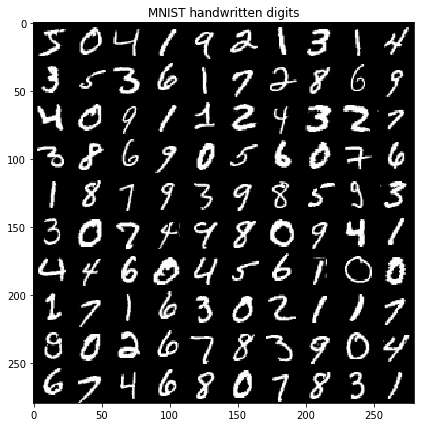

In [5]:
#plot a few MNIST examples
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

In [6]:
from tensorflow.contrib.layers import fully_connected, convolution2d, flatten, batch_norm, max_pool2d, dropout
from tensorflow.python.ops.nn import relu, elu, relu6, sigmoid, tanh, softmax

In [7]:
# define a simple feed forward neural network

# hyperameters of the model
num_classes = 10
channels = x_train.shape[1]
height = x_train.shape[2]
width = x_train.shape[3]
num_filters_conv1 = 16
kernel_size_conv1 = [5, 5] # [height, width]
stride_conv1 = [1, 1] # [stride_height, stride_width]
num_l1 = 100
# resetting the graph ...
reset_default_graph()

# Setting up placeholder, this is where your data enters the graph!
x_pl = tf.placeholder(tf.float32, [None, channels, height, width])
l_reshape = tf.transpose(x_pl, [0, 2, 3, 1]) # TensorFlow uses NHWC instead of NCHW
#is_training = tf.placeholder(tf.bool)#used for dropout

# Building the layers of the neural network
# we define the variable scope, so we more easily can recognise our variables later
l_conv1 = convolution2d(l_reshape, num_filters_conv1, kernel_size_conv1, stride_conv1, scope="l_conv1")
l_flatten = flatten(l_reshape, scope="flatten") # use l_conv1 instead of l_reshape
l1 = fully_connected(l_flatten, num_l1, activation_fn=relu, scope="l1")
#l1 = dropout(l1, is_training=is_training, scope="dropout")
y = fully_connected(l1, num_classes, activation_fn=softmax, scope="y")


In [8]:
y_ = tf.placeholder(tf.float32, [None,num_classes])

cross_entropy = -tf.reduce_sum( y_*tf.log(y+10e-8), reduction_indices = 1)
cross_entropy = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
train_op = optimizer.minimize(cross_entropy)


In [9]:
x = np.random.normal(0,1, (45, 1,28,28)).astype('float32') #dummy data


gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction = 0.2)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.initialize_all_variables())
res = sess.run(fetches=[y], feed_dict={x_pl: x})

#res = sess.run(fetches=[y], feed_dict={x_pl: x, is_training: False}) # for when using dropout
print "y", res[0].shape

Instructions for updating:
Use `tf.global_variables_initializer` instead.
y (45, 10)


In [10]:
from confusionmatrix import ConfusionMatrix

batch_size = 100
num_epochs = 10
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
loss = []

In [11]:
try:
    for epoch in range(num_epochs):
        #Forward->Backprob->Update params
        cur_loss = 0
        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            target_batch = targets_train[idx]
            feed_dict_train = {x_pl: x_batch, y_: onehot(target_batch, num_classes)}
            #feed_dict_train = {x_pl: x_batch, y_: onehot(target_batch, num_classes), is_training: True}
            fetches_train = [train_op, cross_entropy]
            res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
            batch_loss = res[1] #this will do the complete backprob pass
            cur_loss += batch_loss
        loss += [cur_loss/batch_size]

        confusion_valid = ConfusionMatrix(num_classes)
        confusion_train = ConfusionMatrix(num_classes)

        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            targets_batch = targets_train[idx]
            # what to feed our accuracy op
            feed_dict_eval_train = {x_pl: x_batch}
            #feed_dict_eval_train = {x_pl: x_batch, is_training: False}
            # deciding which parts to fetch
            fetches_eval_train = [y]
            # running the validation
            res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
            # collecting and storing predictions
            net_out = res[0] 
            preds = np.argmax(net_out, axis=-1) 
            confusion_train.batch_add(targets_batch, preds)

        confusion_valid = ConfusionMatrix(num_classes)
        for i in range(num_batches_valid):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_valid[idx]
            targets_batch = targets_valid[idx]
            # what to feed our accuracy op
            feed_dict_eval_train = {x_pl: x_batch}
            #feed_dict_eval_train = {x_pl: x_batch, is_training: False}
            # deciding which parts to fetch
            fetches_eval_train = [y]
            # running the validation
            res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
            # collecting and storing predictions
            net_out = res[0]
            preds = np.argmax(net_out, axis=-1) 

            confusion_valid.batch_add(targets_batch, preds)

        train_acc_cur = confusion_train.accuracy()
        valid_acc_cur = confusion_valid.accuracy()

        train_acc += [train_acc_cur]
        valid_acc += [valid_acc_cur]
        print "Epoch %i : Train Loss %e , Train acc %f,  Valid acc %f " \
        % (epoch+1, loss[-1], train_acc_cur, valid_acc_cur)
except KeyboardInterrupt:
    pass
    

Epoch 1 : Train Loss 2.000123e-01 , Train acc 0.699000,  Valid acc 0.598000 
Epoch 2 : Train Loss 1.264937e-01 , Train acc 0.821000,  Valid acc 0.756000 
Epoch 3 : Train Loss 8.189348e-02 , Train acc 0.854000,  Valid acc 0.796000 
Epoch 4 : Train Loss 5.893691e-02 , Train acc 0.883000,  Valid acc 0.818000 
Epoch 5 : Train Loss 4.659734e-02 , Train acc 0.900000,  Valid acc 0.832000 
Epoch 6 : Train Loss 3.884390e-02 , Train acc 0.919000,  Valid acc 0.844000 
Epoch 7 : Train Loss 3.354059e-02 , Train acc 0.929000,  Valid acc 0.848000 
Epoch 8 : Train Loss 2.954198e-02 , Train acc 0.940000,  Valid acc 0.848000 
Epoch 9 : Train Loss 2.634691e-02 , Train acc 0.949000,  Valid acc 0.852000 
Epoch 10 : Train Loss 2.366885e-02 , Train acc 0.957000,  Valid acc 0.854000 



Test set Acc:  0.878000


(<matplotlib.text.Text at 0x7fcee41d1690>,
 (0.75, 1.03))

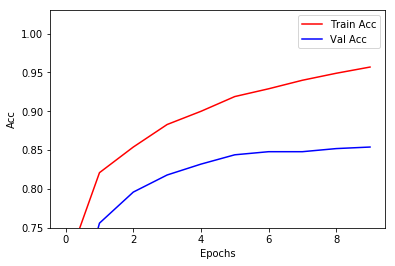

In [12]:


#get test set score
confusion_test = ConfusionMatrix(num_classes)
# what to feed our accuracy op
feed_dict_eval_train = {x_pl: x_test}
#feed_dict_eval_train = {x_pl: x_test, is_training: False}
# deciding which parts to fetch
fetches_eval_train = [y]
# running the validation
res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
# collecting and storing predictions
net_out = res[0] 
preds = np.argmax(net_out, axis=-1) 
confusion_test.batch_add(targets_test, preds)
print "\nTest set Acc:  %f" %(confusion_test.accuracy())


epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])
        

In [13]:


# to start with we print the names of the weights in our graph
# to see what operations we are allowed to perform on the variables in our graph, try:
#print(dir(tf.all_variables()[0]))
# you will notice it has "name" and "value", which we will build a dictionary from
names_and_vars = {var.name: sess.run(var.value()) for var in tf.all_variables()}
print(names_and_vars.keys())
# getting the name was easy, just use .name on the variable object
# getting the value in a numpy array format is slightly more tricky
# we need to first get a variable object, then turn it into a tensor with .value()
# and the evaluate the tensor with sess.run(...)



Instructions for updating:
Please use tf.global_variables instead.
[u'l_conv1/biases:0', u'beta2_power:0', u'l1/biases:0', u'l1/biases/Adam_1:0', u'l1/weights/Adam:0', u'l1/weights:0', u'beta1_power:0', u'y/weights/Adam:0', u'l1/weights/Adam_1:0', u'y/biases:0', u'y/biases/Adam_1:0', u'y/weights/Adam_1:0', u'y/biases/Adam:0', u'l_conv1/weights:0', u'y/weights:0', u'l1/biases/Adam:0']


(5, 5, 1, 16) i.e. the shape is filter_size, filter_size, num_channels, num_filters
learned filter values


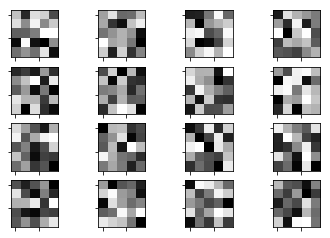

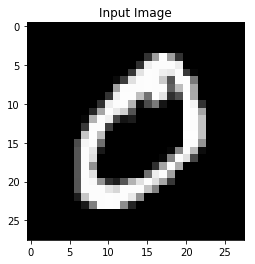

Response from input image convolved with the filters


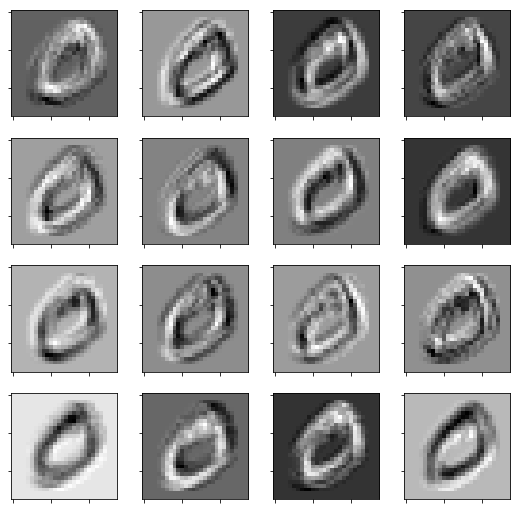

In [14]:


### ERROR - If you get a key error, then you need to define l_conv1 in your model!
if not u'l_conv1/weights:0' in names_and_vars:
    print "You need to go back and define a convolutional layer in the network."
else:
    np_W = names_and_vars[u'l_conv1/weights:0'] # get the filter values from the first conv layer
    print np_W.shape, "i.e. the shape is filter_size, filter_size, num_channels, num_filters"
    filter_size, _, num_channels, num_filters = np_W.shape
    n = int(num_filters**0.5)

    # reshaping the last dimension to be n by n
    np_W_res = np_W.reshape(filter_size, filter_size, num_channels, n, n)
    fig, ax = plt.subplots(n,n)
    print "learned filter values"
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(np_W_res[:,:,0,i,j], cmap='gray',interpolation='none')
            ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
            ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())


    idx = 1
    plt.figure()
    plt.imshow(x_train[idx,0],cmap='gray',interpolation='none')
    plt.title('Input Image')
    plt.show()

    #visalize the filters convolved with an input image
    from scipy.signal import convolve2d
    np_W_res = np_W.reshape(filter_size, filter_size, num_channels, n, n)
    fig, ax = plt.subplots(n,n,figsize=(9,9))
    print "Response from input image convolved with the filters"
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(convolve2d(x_train[1,0],np_W_res[:,:,0,i,j],mode='same'),
                           cmap='gray',interpolation='none')
            ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
            ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())



In [15]:
convolve2d(x_train[1,0],np_W_res[:,:,0,i,j],mode='same').shape

(28, 28)

In [16]:
!wget -N https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz

--2017-04-14 09:55:51--  https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.1.59
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.1.59|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘mnist_cluttered_60x60_6distortions.npz’ not modified on server. Omitting download.



In [17]:
import os
import matplotlib
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected, convolution2d, flatten, max_pool2d
pool = max_pool2d
conv = convolution2d
dense = fully_connected
from tensorflow.python.ops.nn import relu, softmax
from tensorflow.python.framework.ops import reset_default_graph

from spatial_transformer import transformer

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

NUM_EPOCHS = 500
BATCH_SIZE = 256
LEARNING_RATE = 0.001
DIM = 60
NUM_CLASSES = 10
mnist_cluttered = "mnist_cluttered_60x60_6distortions.npz"


Train samples: (50000, 1, 60, 60)
Validation samples: (10000, 1, 60, 60)
Test samples: (10000, 1, 60, 60)


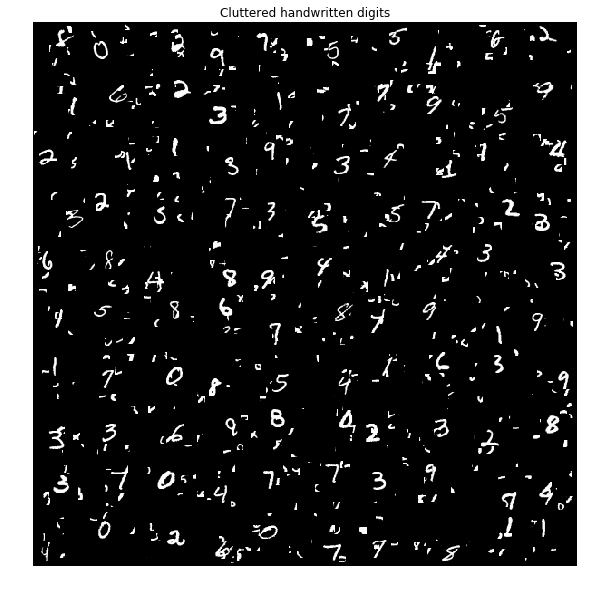

In [18]:
def load_data():
    data = np.load(mnist_cluttered)
    X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
    X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
    X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)

    # reshape for convolutions
    X_train = X_train.reshape((X_train.shape[0], 1, DIM, DIM))
    X_valid = X_valid.reshape((X_valid.shape[0], 1, DIM, DIM))
    X_test = X_test.reshape((X_test.shape[0], 1, DIM, DIM))
    
    print "Train samples:", X_train.shape
    print "Validation samples:", X_valid.shape
    print "Test samples:", X_test.shape

    return dict(
        X_train=np.asarray(X_train, dtype='float32'),
        y_train=y_train.astype('int32'),
        X_valid=np.asarray(X_valid, dtype='float32'),
        y_valid=y_valid.astype('int32'),
        X_test=np.asarray(X_test, dtype='float32'),
        y_test=y_test.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=10,)
data = load_data()

idx = 0
canvas = np.zeros((DIM*10, 10*DIM))
for i in range(10):
    for j in range(10):
        canvas[i*DIM:(i+1)*DIM, j*DIM:(j+1)*DIM] = data['X_train'][idx].reshape((DIM, DIM))
        idx += 1
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')
plt.title('Cluttered handwritten digits')
plt.axis('off')

plt.show()

In [21]:
reset_default_graph()
def build_model(x_pl, input_width, input_height, output_dim,
                batch_size=BATCH_SIZE):
    # Setting up placeholder, this is where your data enters the graph!
    l_reshape = tf.transpose(x_pl, [0, 2, 3, 1]) # TensorFlow uses NHWC instead of NCHW

    # make distributed representation of input image for localization network
    loc_l1 = pool(l_reshape, kernel_size=[2, 2], scope="loc_l1")
    loc_l2 = conv(loc_l1, num_outputs=8, kernel_size=[5, 5], stride=[1, 1], padding="SAME", scope="loc_l2")
    loc_l3 = pool(loc_l2, kernel_size=[2, 2], scope="loc_l3")
    loc_l4 = conv(loc_l3, num_outputs=8, kernel_size=[5, 5], stride=[1, 1], padding="SAME", scope="loc_l4")
    loc_l4_flatten = flatten(loc_l4, scope="loc_l4_flatten")
    loc_l5 = dense(loc_l4_flatten, num_outputs=50, activation_fn=relu, scope="loc_l5")
    # set up weights for transformation (notice we always need 6 output neurons)
    W_loc_out = tf.get_variable("W_loc_out", [50, 6], initializer=tf.constant_initializer(0.0))
    initial = np.array([[1, 0, 0], [0, 1, 0]])
    initial = initial.astype('float32')
    initial = initial.flatten()
    b_loc_out = tf.Variable(initial_value=initial, name='b_loc_out')
    loc_out = tf.matmul(loc_l5, W_loc_out) + b_loc_out

    # spatial transformer
    l_trans1 = transformer(l_reshape, loc_out, out_size=(DIM//3, DIM//3))
    l_trans1.set_shape([None, DIM//3, DIM//3, 1])
    l_trans1_valid = tf.transpose(l_trans1, [0, 2, 3, 1]) # Back into NCHW for validation

    print "Transformer network output shape: ", l_trans1.get_shape()

    # classification network
    class_l1 = conv(l_trans1, num_outputs=16, kernel_size=[3, 3], scope="class_l1")
    class_l2 = pool(class_l1, kernel_size=[2, 2], scope="class_l2")
    class_l3 = conv(class_l2, num_outputs=16, kernel_size=[3, 3], scope="class_l3")
    class_l4 = pool(class_l3, kernel_size=[2, 2], scope="class_l4")
    class_l4_flatten = flatten(class_l4, scope="class_l4_flatten")
    class_l5 = dense(class_l4_flatten, num_outputs=256, activation_fn=relu, scope="class_l5")
    l_out = dense(class_l5, num_outputs=output_dim, activation_fn=softmax, scope="l_out")

    return l_out, l_trans1_valid


In [26]:
DIM//3

20

In [27]:

x_pl = tf.placeholder(tf.float32, [None, 1, DIM, DIM])

In [29]:

model, l_transform = build_model(x_pl, DIM, DIM, NUM_CLASSES)
#model_params = lasagne.layers.get_all_params(model, trainable=True)

ValueError: Variable W_loc_out already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "<ipython-input-21-6b9e1492a8ab>", line 15, in build_model
    W_loc_out = tf.get_variable("W_loc_out", [50, 6], initializer=tf.constant_initializer(0.0))
  File "<ipython-input-22-4bbb28a9d9fb>", line 3, in <module>
    model, l_transform = build_model(x_pl, DIM, DIM, NUM_CLASSES)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


In [30]:
# y_ is a placeholder variable taking on the value of the target batch.
y_pl = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES])
lr_pl = tf.placeholder(tf.float32, shape=[])

# computing cross entropy per sample
cross_entropy = -tf.reduce_sum(y_pl * tf.log(model+1e-8), reduction_indices=[1])

# averaging over samples
cross_entropy = tf.reduce_mean(cross_entropy)

# defining our optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr_pl)

# applying the gradients
train_op = optimizer.minimize(cross_entropy)



# test the forward pass
x = np.random.normal(0,1, (45, 1,60,60)).astype('float32') #dummy data
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.initialize_all_variables())
res = sess.run(fetches=[model], feed_dict={x_pl: x})
print "y", res[0].shape



NameError: name 'model' is not defined